In [26]:
import numpy as np
import torch.utils.data as dutils
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from network import TinyNet

In [27]:
TRAIN_SPLIT = 0.8

print('Loading the dataset into memory')
dataset = np.load('dataset.npy')
print(f'Finished loading the dataset, found {len(dataset)} items')

class Dataset(dutils.Dataset):
    def __init__(self, subset='training'):
        super().__init__()
    
        self.subset = subset
        
        val_split = (1 - TRAIN_SPLIT) / 2
    
        self.num_train = int(len(dataset) * TRAIN_SPLIT)
        self.num_val = int(len(dataset) * val_split)
    
        if subset == 'training':
            self.num_items = self.num_train
        elif subset == 'validation':
            self.num_items = self.num_val
        elif subset == 'testing':
            self.num_items = len(dataset) - self.num_train - self.num_val
        else:
            self.num_items = len(dataset)
            print('Warning: Unknown subset, using entire dataset')
    
        print(f'Using {self.num_items} items for {subset}')
	
    def __len__(self):
        return self.num_items
    
    def __getitem__(self, idx):
        offset = 0
        if self.subset == 'validation':
            offset += self.num_train
        if self.subset == 'testing':
            offset += self.num_train + self.num_val
        example = dataset[offset + idx]
        inputs = example[:-1]
        label = example[-1]
        return inputs, label
    
train_ds = Dataset(subset='training')
val_ds = Dataset(subset='validation')
test_ds = Dataset(subset='testing')

train_dl = dutils.DataLoader(train_ds, batch_size=256, shuffle=True)
val_dl = dutils.DataLoader(val_ds, batch_size=256, shuffle=True)
test_dl = dutils.DataLoader(test_ds, batch_size=256, shuffle=True)

Loading the dataset into memory
Finished loading the dataset, found 318011 items
Using 254408 items for training
Using 31801 items for validation
Using 31802 items for testing


In [28]:
len(dataset[0])

334

In [29]:
device = (
	'cuda' if torch.cuda.is_available() else
	'mps' if torch.backends.mps.is_available() else
	'cpu'
)

print(f'Using {device}')

Using cuda


In [30]:
net = TinyNet()
net = net.to(device)

optim = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [31]:
def train(dl):
	avg_loss = 0
	avg_acc = 0
	for inputs, targets in tqdm(dl):
		inputs = inputs.to(device)
		targets = targets.to(device)

		preds = net(inputs)
		preds = preds.view(-1)
		loss = loss_fn(preds, targets)

		net.zero_grad()
		loss.backward()
		optim.step()

		avg_loss += loss.item()

		preds = torch.sigmoid(preds)
		acc = (preds.round() == targets).float().sum().item() / len(targets)
		avg_acc += acc
	avg_loss /= len(dl)
	avg_acc /= len(dl)

	return avg_loss, avg_acc

In [32]:
def test(dl):
	avg_loss = 0
	avg_acc = 0
	for inputs, targets in tqdm(dl):
		inputs = inputs.to(device)
		targets = targets.to(device)

		with torch.no_grad():
			preds = net(inputs)
		preds = preds.view(-1)
		loss = loss_fn(preds, targets)

		avg_loss += loss.item()

		preds = torch.sigmoid(preds)
		acc = (preds.round() == targets).float().sum().item() / len(targets)
		avg_acc += acc
	avg_loss /= len(dl)
	avg_acc /= len(dl)

	return avg_loss, avg_acc

In [33]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
for epoch in range(20):
	print(f'Epoch {epoch+1}')
	t_loss, t_accuracy = train(train_dl)
	v_loss, v_accuracy = test(val_dl)
	train_losses.append(t_loss)
	train_accs.append(t_accuracy)
	val_losses.append(v_loss)
	val_accs.append(v_accuracy)
	print(f'Training Loss: {t_loss}')
	print(f'Training Accuracy: {t_accuracy}')
	print(f'Validation Loss: {v_loss}')
	print(f'Validation Accuracy : {v_accuracy}')

Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 506.12it/s]


Training Loss: 0.5294301972182943
Training Accuracy: 0.7106309733400402
Validation Loss: 0.514294766664505
Validation Accuracy : 0.7248952850877194
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 488.03it/s]


Training Loss: 0.4860506603115761
Training Accuracy: 0.7472879464285714
Validation Loss: 0.45659969305992126
Validation Accuracy : 0.7718788377192982
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 490.27it/s]


Training Loss: 0.4076284041527052
Training Accuracy: 0.8018207683601609
Validation Loss: 0.39526342606544496
Validation Accuracy : 0.8092680921052631
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 519.09it/s]


Training Loss: 0.31211343779410394
Training Accuracy: 0.8573858777665996
Validation Loss: 0.27573626601696016
Validation Accuracy : 0.8784232456140351
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 473.95it/s]


Training Loss: 0.2370939699996645
Training Accuracy: 0.8959637512575452
Validation Loss: 0.22133854246139525
Validation Accuracy : 0.9027987938596491
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 496.99it/s]


Training Loss: 0.18084199132933704
Training Accuracy: 0.9228661028672033
Validation Loss: 0.1707268618941307
Validation Accuracy : 0.926688048245614
Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 474.97it/s]


Training Loss: 0.13800170672101753
Training Accuracy: 0.942941869969819
Validation Loss: 0.1365189829468727
Validation Accuracy : 0.942734649122807
Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 455.31it/s]


Training Loss: 0.10396967018004394
Training Accuracy: 0.958114782444668
Validation Loss: 0.09622021773457527
Validation Accuracy : 0.960844298245614
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 477.05it/s]


Training Loss: 0.08671412493666293
Training Accuracy: 0.9654957872233401
Validation Loss: 0.07300280234217643
Validation Accuracy : 0.970750548245614
Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 477.61it/s]


Training Loss: 0.06578520225582109
Training Accuracy: 0.9745263770120725
Validation Loss: 0.0720497776567936
Validation Accuracy : 0.971625
Epoch 11


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 499.99it/s]


Training Loss: 0.05597823522460293
Training Accuracy: 0.9785208123742455
Validation Loss: 0.06708176147937775
Validation Accuracy : 0.974265899122807
Epoch 12


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 548.22it/s]


Training Loss: 0.04609435913855701
Training Accuracy: 0.9827975666498994
Validation Loss: 0.041924773648381236
Validation Accuracy : 0.98478125
Epoch 13


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 441.11it/s]


Training Loss: 0.04048038087082536
Training Accuracy: 0.9852317027162978
Validation Loss: 0.03163569095730782
Validation Accuracy : 0.989109649122807
Epoch 14


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 452.68it/s]


Training Loss: 0.03563880258365356
Training Accuracy: 0.9869900653923541
Validation Loss: 0.037486795887351036
Validation Accuracy : 0.987344298245614
Epoch 15


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 486.58it/s]


Training Loss: 0.03138836554928085
Training Accuracy: 0.9887859972334004
Validation Loss: 0.05547779740393162
Validation Accuracy : 0.979625548245614
Epoch 16


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 520.75it/s]


Training Loss: 0.029936876458114003
Training Accuracy: 0.9891717492454729
Validation Loss: 0.06236524088680744
Validation Accuracy : 0.9778283991228071
Epoch 17


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 517.83it/s]


Training Loss: 0.02356392853182199
Training Accuracy: 0.9918838028169014
Validation Loss: 0.019880865424871445
Validation Accuracy : 0.99409375
Epoch 18


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 514.89it/s]


Training Loss: 0.026787075096267224
Training Accuracy: 0.990366888832998
Validation Loss: 0.04040757209062576
Validation Accuracy : 0.985015899122807
Epoch 19


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 513.04it/s]


Training Loss: 0.021776006273387497
Training Accuracy: 0.9922296277665996
Validation Loss: 0.025384029175154865
Validation Accuracy : 0.99159375
Epoch 20


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 507.11it/s]

Training Loss: 0.022208050747989476
Training Accuracy: 0.9923828910965795
Validation Loss: 0.023213800732046364
Validation Accuracy : 0.99196875


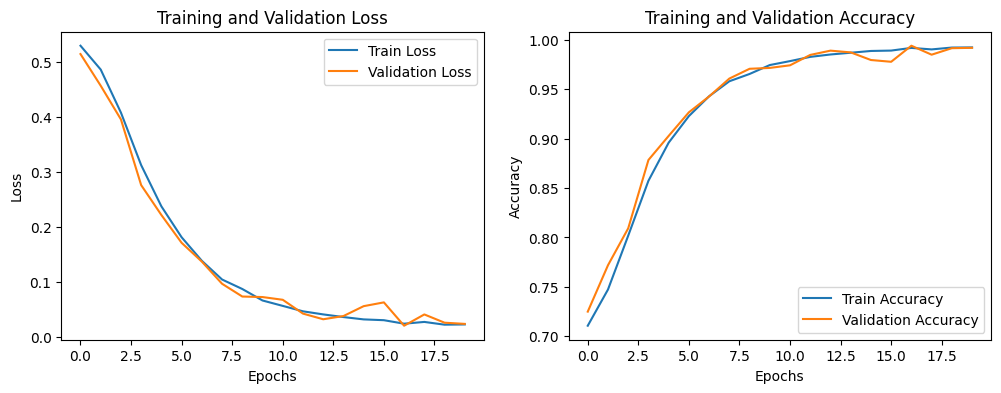

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

plt.show()

In [35]:
loss, accuracy = test(test_dl)
print(f"Loss: {loss}, Accuracy: {accuracy}")

100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 523.68it/s]

Loss: 0.023796460662037135, Accuracy: 0.99153125


In [36]:
def get_accuracy_by_minute():
    acc_dic = {}
    count_dic = {}
    for batch, targets in tqdm(test_dl):
        batch = batch.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = net(batch)
        predictions = torch.sigmoid(predictions)
        for i in range(len(batch)):
            tstep = str(int(batch[i][-1] * 30))
            if tstep in acc_dic:
                if predictions[i].round() == targets[i]:
                    acc_dic[tstep] += 1
                count_dic[tstep] += 1
            else:
                acc_dic[tstep] = 0
                if predictions[i].round() == targets[i]:
                    acc_dic[tstep] = 1
                count_dic[tstep] = 1
    return acc_dic, count_dic

In [37]:
acc_dic, count_dic = get_accuracy_by_minute()

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 26.06it/s]


In [38]:
acc_dic

{'28': 625,
 '17': 990,
 '22': 897,
 '27': 745,
 '2': 1081,
 '9': 1017,
 '11': 1041,
 '13': 1022,
 '4': 1047,
 '18': 956,
 '23': 913,
 '21': 953,
 '15': 1050,
 '1': 1012,
 '19': 944,
 '7': 1042,
 '10': 1028,
 '30': 540,
 '16': 1068,
 '24': 894,
 '0': 1049,
 '20': 932,
 '32': 352,
 '12': 989,
 '8': 1044,
 '5': 1026,
 '3': 1013,
 '40': 49,
 '25': 828,
 '36': 163,
 '35': 201,
 '37': 141,
 '38': 104,
 '43': 21,
 '29': 563,
 '6': 1065,
 '26': 802,
 '14': 1060,
 '31': 461,
 '34': 259,
 '33': 301,
 '39': 81,
 '51': 2,
 '41': 47,
 '46': 13,
 '42': 43,
 '47': 6,
 '44': 26,
 '45': 11,
 '54': 3,
 '49': 2,
 '52': 2,
 '50': 3,
 '48': 4}

In [39]:
for n in acc_dic.keys():
    acc_dic[n] /= count_dic[n]

In [40]:
idx = 0
acc_by_time = []
while str(idx) in acc_dic:
    n = acc_dic[str(idx)]
    acc_by_time.append(n)
    idx += 1

In [41]:
acc_by_time[20]

0.9914893617021276

In [42]:
acc_by_time

[0.9712962962962963,
 0.9721421709894332,
 0.976513098464318,
 0.9759152215799615,
 0.9858757062146892,
 0.9884393063583815,
 0.9833795013850416,
 0.9886148007590133,
 0.9914529914529915,
 0.9921951219512195,
 0.9922779922779923,
 0.9961722488038277,
 0.9949698189134809,
 0.9931972789115646,
 0.9906542056074766,
 0.9980988593155894,
 0.994413407821229,
 0.9939759036144579,
 0.9979123173277662,
 0.9957805907172996,
 0.9914893617021276,
 0.9947807933194155,
 0.9988864142538976,
 0.9934711643090316,
 0.9977678571428571,
 0.9987937273823885,
 1.0,
 0.9973226238286479,
 0.9952229299363057,
 1.0,
 1.0,
 1.0,
 0.9971671388101983,
 0.9933993399339934,
 1.0,
 1.0,
 1.0,
 0.9929577464788732,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

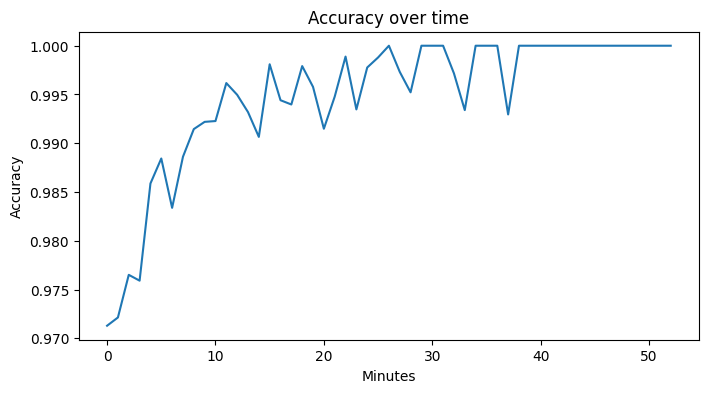

In [43]:
plt.figure(figsize=(8, 4))
plt.title('Accuracy over time')
plt.plot(acc_by_time)
plt.xlabel('Minutes')
plt.ylabel('Accuracy')
plt.show()

In [44]:
inputs, targets = next(iter(train_dl))

In [45]:
len(inputs)

256

In [46]:
len(targets)

256

In [47]:
net = net.cpu()

In [48]:
torch.save(net.state_dict(), 'net.pth')